Script initialization:

 - CLASS Python extension successfully imported.
 - Setting file lcdm_settings_used.ini found.


Successfully imported settings:

 - A_s =  2.215e-09
 - n_s =  0.9619
 - h =  0.67556
 - omega_b =  0.022032
 - omega_cdm =  0.12038
 - N_eff =  3.046
 - boxsize =  320.0
 - Ngrid =  512
 - h =  0.67556
 - snapshot redshifts =  [30.0, 10.0, 3.0, 0.0]
 - Pk file base =  lcdm_pk
 - Pk redshifts =  [50.0, 30.0, 10.0, 3.0, 1.0, 0.0]


Files in the current folder and subfolders:

 - Found 1 density files.
 - Found 3 Pk files, of which 3 has been requested to be plotted.


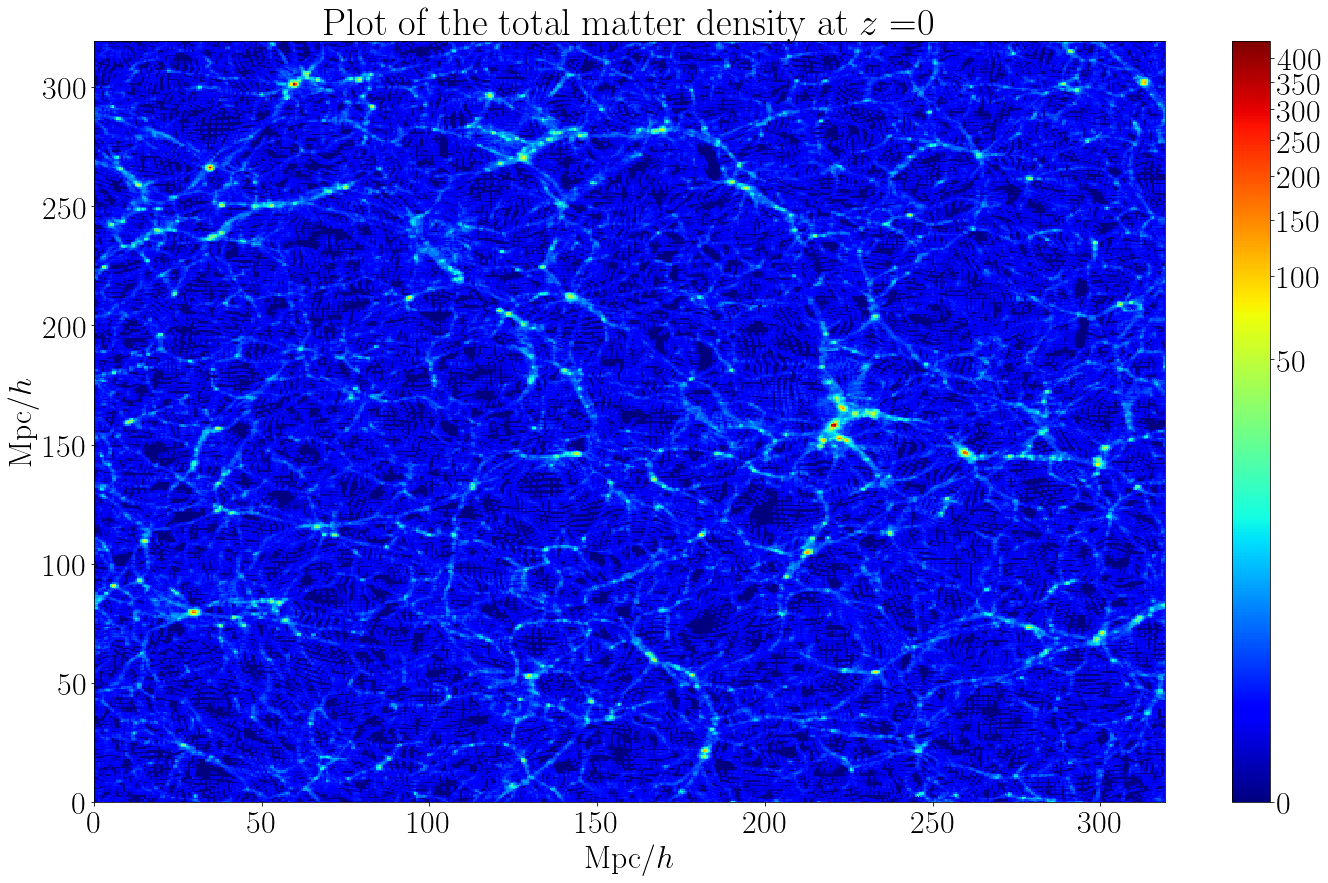

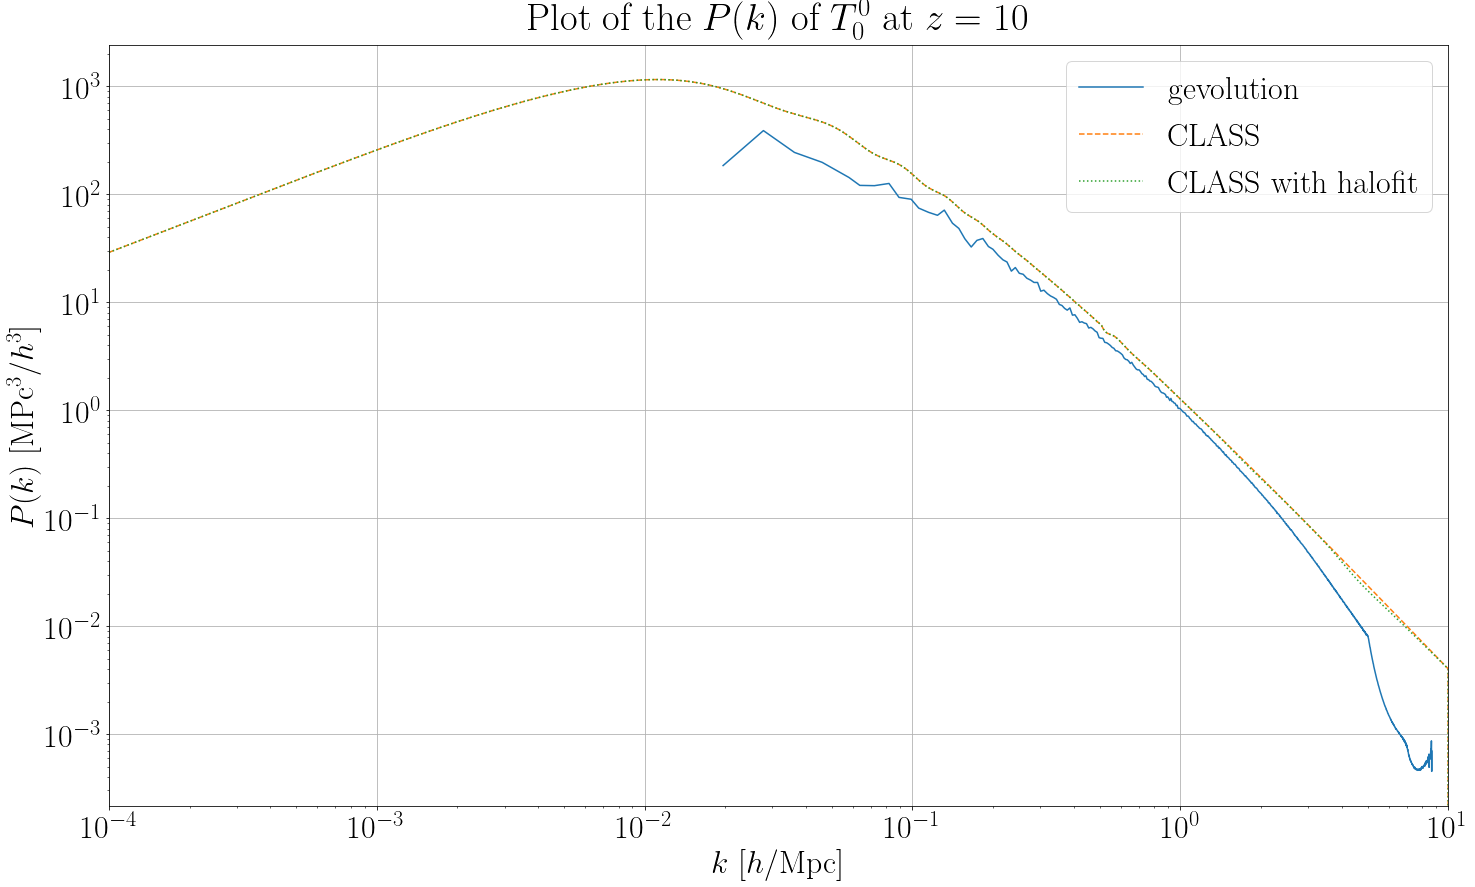

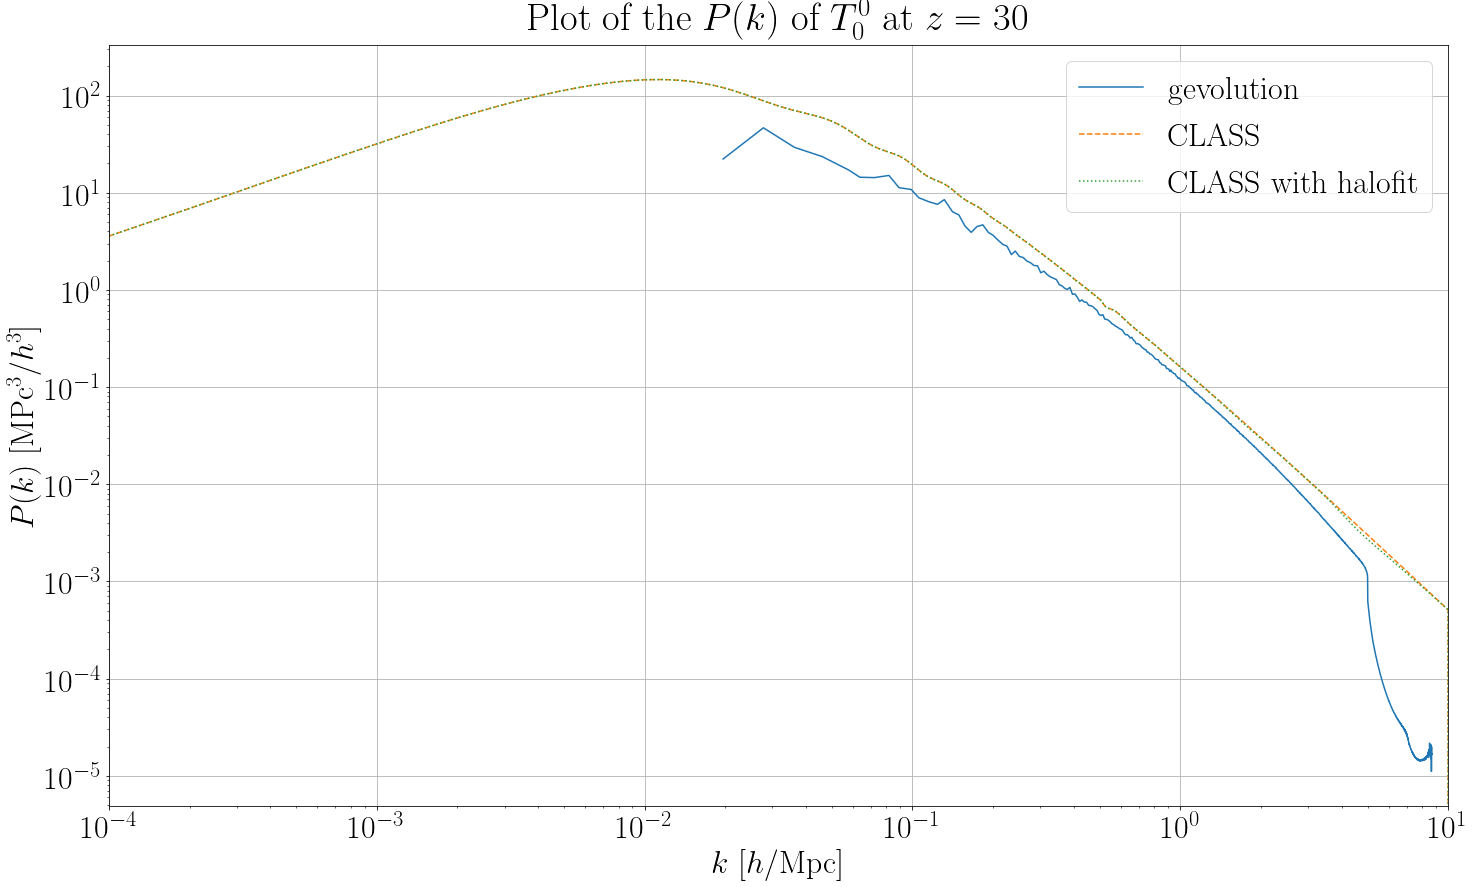

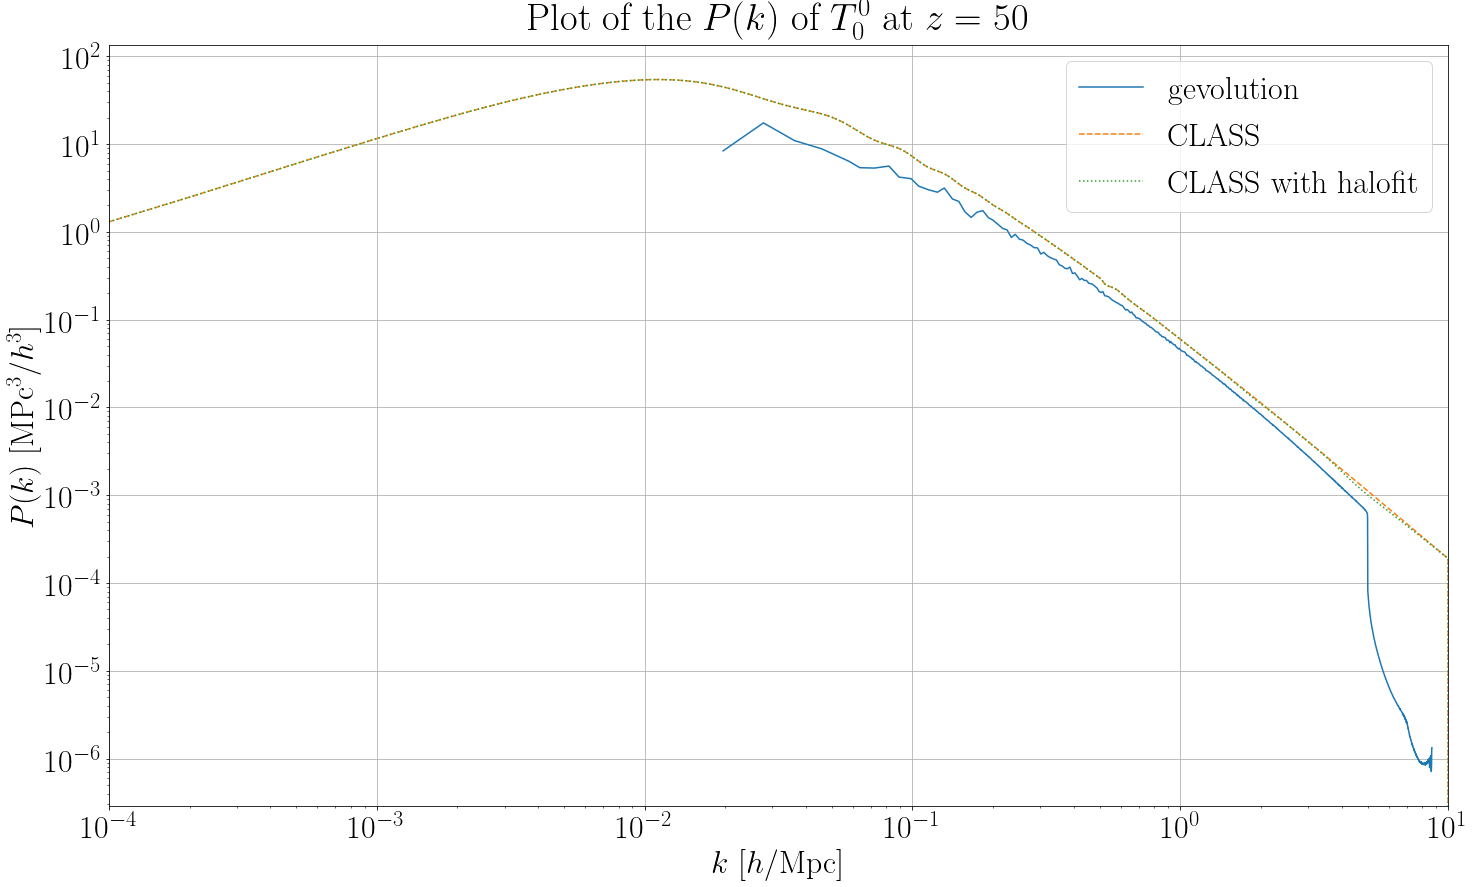

In [5]:
%matplotlib inline


# SETTINGS


# Plots: format
text_size = 32
fig_size_x = 24
fig_size_y = 14

# Plots: explenatory titles (bigger values = longer explenatory titles)
exp_titles = 1

# Density plots: switch on/off (0) density plots
density_plot_on = 1

# Density Plots: index of the z dimension to be plotted
z_plot = 1

# Density Plots: normalization for the plots
# This option can help normalizing the color map in a way that, for instance, gives the smaller values
# of the density a smaller "color space". The data are not normalized or changed by this operation.
#   - "1": Logarithmic (can give void regions if some values of the density are zero)
#   - "2": Power law x^gamma
#   - other: Standard (no normalization)
normalization = 2
# If 2: Power law
gamma = 0.25

# Density Plots: contour plot (EXPERIMENTAL, the standard plots will also be also plotted)
# This option usually don't give good results for poor resolutions and low redshifts
contour_plot = 0

# Density Plots: color map for the density plots
# Complete list of color maps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
cmap_set = 'jet'

# Pk plots: switch on/off (0) Pk plots
Pk_plot_on = 1

# Pk Plots: Pk quantities to plot (in the same format of gevolution)
# Quantities not found in the output folder will be ignored
# List of quantites (provided they were computed): hij phi B chi
Pk_plot_q = ['T00']

# Pk Plots: redshifts to plot
# Redshift not computed will be ignored
Pk_plot_z = [50.0, 30.0, 10.0]

# Pk Plots: use CLASS for comparison results in the plot (only for total matter plot)
Pk_classy = 1


# END OF SETTINGS





# SCRIPT

# INITIALIZATION

print("Script initialization:\n")

import numpy as np
import os, sys, warnings
import h5py
import matplotlib
import numpy as np
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

# Check if classy is available
def module_exists(module_name):
    try:
        __import__(module_name)
    except ImportError:
        return False
    else:
        return True

if not module_exists('classy') and Pk_classy == 1:
    Pk_classy = 0
    warnings.warn("You requested to use CLASS results, but I can not find the classy Python module.\nAll calls for CLASS will be ignored.")
elif module_exists('classy') and Pk_classy == 1:
    from classy import Class
    print(" - CLASS Python extension successfully imported.")

# Initializing the settings, reading from the output .ini file

outsetfile=''

for file in os.walk(os.path.abspath(os.curdir)):
    for el in file[2]:
        if el.endswith(".ini"):
            outsetfile=el
            
if outsetfile=='':
    sys.exit("Error. Cannot find the output setting file.\nCheck the presence of the .ini file in the script folder.")
else:
    print(" - Setting file " + outsetfile + " found.")

Ngrid = 0
boxsize = 0.
pk_file_base = ""
A_s = 2.215e-9
n_s = 0.9619
h = 0.67556
omega_b = 0.022032
omega_cdm = 0.12038
N_eff = 3.046
T_cmb=2.7255

print("\n")
print("Successfully imported settings:\n")
with open(outsetfile, 'rt') as f:
    data = f.readlines()
for line in data:
    if line.__contains__('Ngrid ='):
        Ngrid = int(line[line.find('= ')+2:line.find('/n')])
        print(" - Ngrid = ", Ngrid)
    elif line.__contains__('boxsize ='):
        boxsize = float(line[line.find('= ')+2:line.find('/n')])
        print(" - boxsize = ", boxsize)
    elif line.__contains__('snapshot redshifts ='):
        snap_z = [float(el) if el.isdigit() else el for el in line[line.find('= ')+2:line.find('/n')].split(", ")]
        print(" - snapshot redshifts = ", snap_z)
    elif line.__contains__('Pk file base ='):
        pk_file_base = line[line.find('= ')+2:line.find('/n')]
        print(" - Pk file base = ", pk_file_base)
    elif line.__contains__('Pk redshifts ='):
        Pk_z = [float(el) if el.isdigit() else el for el in line[line.find('= ')+2:line.find('/n')].split(", ")]
        print(" - Pk redshifts = ", Pk_z)
    elif line.__contains__('omega_b =') and Pk_classy==1:
        omega_b = float(line[line.find('= ')+2:line.find('/n')])
        print(" - omega_b = ", omega_b)
    elif line.__contains__('omega_cdm =') and Pk_classy==1:
        omega_cdm = float(line[line.find('= ')+2:line.find('/n')])
        print(" - omega_cdm = ", omega_cdm)
    elif line.__contains__('h =') and Pk_classy==1:
        if line[line.find('= ')+2:line.find('/n')] is float:
            h = float(line[line.find('= ')+2:line.find('/n')])
        print(" - h = ", h)
    elif line.__contains__('n_s =') and Pk_classy==1:
        n_s = float(line[line.find('= ')+2:line.find('/n')])
        print(" - n_s = ", n_s)
    elif line.__contains__('A_s =') and Pk_classy==1:
        A_s = float(line[line.find('= ')+2:line.find('/n')])
        print(" - A_s = ", A_s)
    elif (line.__contains__('N_ur =') or line.__contains__('N_eff =')) and Pk_classy==1:
        N_eff = float(line[line.find('= ')+2:line.find('/n')])
        print(" - N_eff = ", N_eff)

if pk_file_base=="":
    sys.exit("Error. Pk file base cannot be null.\nChange the setting .ini and rename the Pk files if no Pk file base was set during the simulation.")
    
T00file = []
Pkfile = []
T00_title_z = []
Pk_title_z = []
Pk_title_q = []

i=0
for file in os.walk(os.path.abspath(os.curdir)):
    for el in file[2]:
        if el.endswith("_T00.h5"):
            T00file.append(el)
            T00_title_z.append(int(el[el.find('snap')+4:el.find('snap')+7]))
        elif el.startswith(pk_file_base):
            i=i+1
            z_index=int(el[el.find(pk_file_base)+len(pk_file_base):el.find(pk_file_base)+len(pk_file_base)+3])
            if any(ext in el for ext in Pk_plot_q) and Pk_z[z_index] in Pk_plot_z:
                    Pkfile.append(el)
                    Pk_title_z.append(z_index)
                    Pk_title_q.append(el[el.find(pk_file_base)+len(pk_file_base)+4:el.find('.')])

if T00file==[]:
    warnings.warn("Cannot find any T00.h5 file: no density T00 will be plotted.")
if Pkfile==[]:
    warnings.warn("Cannot find any Pk file: no Pk will be plotted.")

print("\n")    
print("Files in the current folder and subfolders:\n")
print(" - Found %d density files." % len(T00file))
if density_plot_on==0: print("   But none will be plotted.")
print(" - Found " + str(i) + " Pk files, of which " + str(len(Pkfile)) + " has been requested to be plotted.")
if Pk_plot_on==0: print("   But none will be plotted.")


# PLOT

# Part to obtain LaTex formatted text
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}

matplotlib.rc('font', **font)


# Plots of the total matter density (CDM + baryons)

cmap = plt.get_cmap(cmap_set)

if density_plot_on!=0:
    
    dset=[]
    for el in T00file:
        f = h5py.File(el, 'r')
        dset.append(f['data'])

    for j in range(len(T00file)):

        dsetplot=dset[j]

        xi, yi = np.mgrid[0:Ngrid, 0:Ngrid]
        zi = dsetplot[0:Ngrid,0:Ngrid,z_plot]

        plt.figure(figsize=(fig_size_x,fig_size_y))
        if exp_titles==1:
            plt.title("Plot of the total matter density at $z=$"+str(int(snap_z[T00_title_z[j]])))
        elif exp_titles>1:
            plt.title("Plot of the total matter density at $z=$"+str(int(snap_z[T00_title_z[j]]))+"(res:"+str(Ngrid)+")")
        plt.xlabel("Mpc/$h$")
        plt.ylabel("Mpc/$h$")

        if normalization==1:
            plt.pcolormesh(boxsize/Ngrid*xi, boxsize/Ngrid*yi, zi.reshape(xi.shape),cmap=cmap, norm=colors.LogNorm(vmin=Z.min()+0.1, vmax=Z.max()))
        elif normalization==2:
            plt.pcolormesh(boxsize/Ngrid*xi, boxsize/Ngrid*yi, zi.reshape(xi.shape),cmap=cmap, norm=colors.PowerNorm(gamma=gamma))
        else:
            plt.pcolormesh(boxsize/Ngrid*xi, boxsize/Ngrid*yi, zi.reshape(xi.shape),cmap=cmap)

        plt.colorbar()
        plt.show()

        if contour_plot==1:

            levels = MaxNLocator(nbins=15).tick_values(zi.min(), zi.max())
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

            res=10
            dx, dy = res/Ngrid, res/Ngrid
            y, x = np.mgrid[slice(1, res + 1 + dy, dy),slice(1, res + 1 + dx, dx)]

            plt.figure(figsize=(fig_size_x,fig_size_y))
            if exp_titles==1:
                plt.title("Plot of the total matter density at $z=$"+str(int(snap_z[T00_title_z[j]])))
            elif exp_titles>1:
                plt.title("Plot of the total matter density at $z=$"+str(int(snap_z[T00_title_z[j]]))+"(res:"+str(Ngrid)+")")
            plt.xlabel("Mpc/$h$")
            plt.ylabel("Mpc/$h$")

            if normalization==1:
                plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2.,zi,levels=levels,cmap=cmap,norm=colors.LogNorm(vmin=Z.min()+0.1, vmax=Z.max()))
            elif normalization==2:
                plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2.,zi,levels=levels,cmap=cmap,norm=colors.PowerNorm(gamma=gamma))
            else:
                plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2.,zi,levels=levels,cmap=cmap)

            plt.colorbar()
            plt.show()

if Pk_plot_on!=0:
    
    # Format the title in LaTex form
    for i in range(len(Pk_title_q)):
        if Pk_title_q[i]=='hij':
            Pk_title_q[i]='$h_{ij}$'
        elif Pk_title_q[i]=='phi':
            Pk_title_q[i]='$\\phi$'
        elif Pk_title_q[i]=='B':
            Pk_title_q[i]='$B$'
        elif Pk_title_q[i]=='chi':
            Pk_title_q[i]='$\\chi$'
        elif Pk_title_q[i]=='T00':
            Pk_title_q[i]='$T_0^0$'
    
    for j in range(len(Pkfile)):
    
        # Data loaded as:
        #     k, Pk, sigma(k), sigma (Pk)
        data = np.loadtxt(Pkfile[j],usecols=(0, 1, 2, 3),unpack=True)

        plt.figure(figsize=(fig_size_x,fig_size_y))
        if exp_titles==1:
            plt.title("Plot of the $P(k)$ of " + Pk_title_q[j] + " at $z=$ "+str(int(Pk_z[Pk_title_z[j]])))
        elif exp_titles>1:
            plt.title("Plot of the $P(k)$ of " + Pk_title_q[j] + " at $z=$ "+str(int(Pk_z[Pk_title_z[j]]))+"(res:"+str(Ngrid)+")")
        plt.xlabel("$k$ [$h$/Mpc]")
        plt.ylabel("$P(k)$ [MPc$^3$/$h^3$]")

        if Pk_classy and Pk_title_q[j]=='$T_0^0$':
            
            # CLASS parameters
            params_lcdm = {
                'output':'lCl,tCl,mPk',
                'omega_b':omega_b,
                'omega_cdm':omega_cdm,
                'h':h,
                'N_eff':N_eff,
                'T_cmb':T_cmb,
                #'YHe':YHe,
                #'z_reio':z_reio,
                'A_s':A_s,
                'n_s':n_s,
                'write background':'y',
                #'P_k_max_h/Mpc':2,
                'gauge':'newtonian',
                'k_output_values':'10,1e-4',
                'lensing':'y',
                'input_verbose':10,
                'background_verbose':10,
            }
            params_lcdm_nl = {
                'output':'lCl,tCl,mPk',
                'omega_b':omega_b,
                'omega_cdm':omega_cdm,
                'h':h,
                'N_eff':N_eff,
                'T_cmb':T_cmb,
                #'YHe':YHe,
                #'z_reio':z_reio,
                'A_s':A_s,
                'n_s':n_s,
                'write background':'y',
                #'P_k_max_h/Mpc':2,
                'gauge':'newtonian',
                'k_output_values':'10,1e-4',
                'lensing':'y',
                'non linear':'halofit',
                'input_verbose':10,
                'background_verbose':10,
            }

            cosmo = Class()
            
            # shift+tab after ( to obtain informations about the function
            cosmo.set(params_lcdm)
            cosmo.set({'z_pk':float(Pk_z[Pk_title_z[j]])})
            cosmo.compute()

            bkg_lcdm=cosmo.get_background()

            PK_lcdm=np.zeros(100000)
            k = 1e-4*np.array(range(1,100001))

            for i in range (0,99999):
                PK_lcdm[i]=cosmo.pk(k[i],int(Pk_z[Pk_title_z[j]]))

            cosmo.struct_cleanup()
            cosmo.empty()

            cosmo.set(params_lcdm_nl)
            cosmo.set({'z_pk':float(Pk_z[Pk_title_z[j]])})
            cosmo.compute()

            bkg_lcdm_nl=cosmo.get_background()

            PK_lcdm_nl=np.zeros(100000)
            k = 1e-4*np.array(range(1,100001))

            for i in range (0,99999):
                PK_lcdm_nl[i]=cosmo.pk(k[i],int(Pk_z[Pk_title_z[j]]))

            cosmo.struct_cleanup()
            cosmo.empty()
            
            a=1./(1.+float(Pk_z[Pk_title_z[j]]))

            plt.loglog(data[0], 2.*np.pi*np.pi*data[1]/data[0]/data[0]/data[0]*a*a*a*a*a*a/3.120420e-01/3.120420e-01, label='gevolution')
            plt.loglog(k, PK_lcdm, label='CLASS', linestyle='dashed')
            plt.loglog(k, PK_lcdm_nl, label='CLASS with halofit', linestyle='dotted')
            plt.legend()
            plt.xlim(1e-4,10)
            #plt.ylim(0,1e7)
        elif not Pk_classy and Pk_title_q[j]=='$T_0^0$':
            plt.loglog(data[0],2.*np.pi*np.pi*data[1]/data[0]/data[0]/data[0]*a*a*a*a*a*a/3.120420e-01/3.120420e-01)
        else:
            plt.loglog(data[0],2.*np.pi*np.pi*data[1]/data[0]/data[0]/data[0]*a*a*a*a*a*a)

        plt.grid(True)

        plt.show()